In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction_for_coupled_momentum_model

from project_ssms.coupled_momentum_observation import CoupledMomentumObservation
from project_ssms.feature_funcs import feature_func_single
from project_ssms.momentum_utils import filter_traj_by_speed

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

Goal: design a model that generates data with following behaviors:


- bimodal occupancy.

- switching between two modes


Also, in this notebook, I would like to explore incorporating speed and acc to see if that helps!

# data loading

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

session_data = datasets_processed[0].render_trajectories([3,8])
traj0 = np.concatenate((session_data), axis=1)

In [4]:
speed_per_dim = np.diff(traj0, axis=0)

In [5]:
np.max(speed_per_dim, axis=0)

array([26.74338913, 26.91288567, 43.37775815, 26.42318075])

In [6]:
np.min(speed_per_dim, axis=0)

array([-24.63852167, -26.47611463, -43.59845507, -30.09817195])

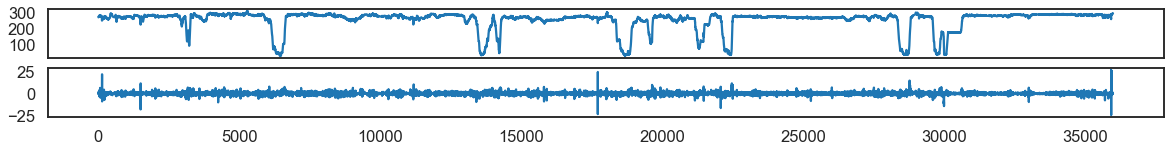

In [7]:
plt.figure(figsize=(20,2))
plt.subplot(2,1,1)
plt.plot(traj0[:,0])
plt.subplot(2,1,2)
plt.plot(speed_per_dim[:,0]);

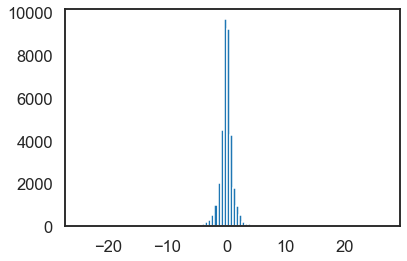

In [8]:
plt.hist(speed_per_dim[:,0], bins=100);

# data processing

In [9]:
f_traj = filter_traj_by_speed(traj0, q1=0.99, q2=0.99)

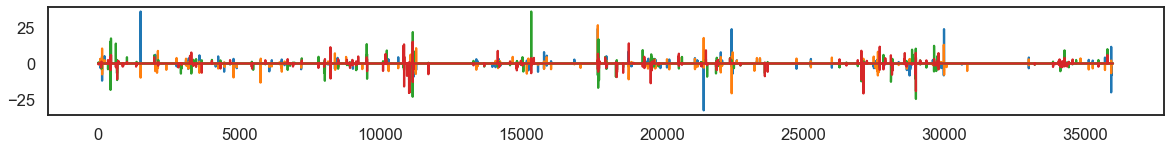

In [10]:
plt.figure(figsize=(20,2))

plt.plot(f_traj-traj0);

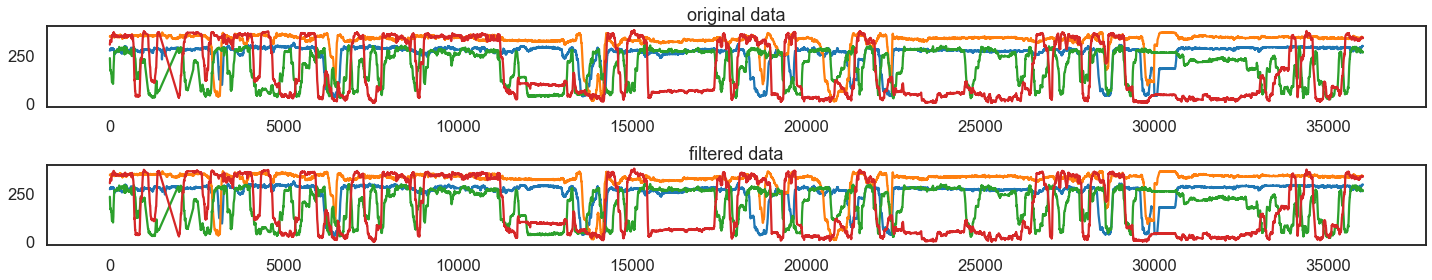

In [11]:
plt.figure(figsize=(20,4))

plt.subplot(2,1,1)
plt.plot(traj0)
plt.title("original data")

plt.subplot(2,1,2)
plt.plot(f_traj)
plt.title("filtered data")

plt.tight_layout()

In [12]:
speed_x = np.diff(f_traj, axis=0)

In [13]:
np.max(abs(speed_x), axis=0)

array([10.13334823, 10.94461803, 21.90342061, 15.10834098])

In [14]:
np.min(f_traj, axis=0)

array([30.29477072,  6.87015009, 17.63016152, -1.43330193])

In [15]:
np.max(f_traj, axis=0)

array([312.4153142 , 366.82321405, 299.37139297, 379.03557754])

In [16]:
arena_xmin = 10
arena_xmax = 320

arena_ymin = -10
arena_ymax = 390

# 1. An Input driven model:

Observation: concatenation of position and speed.

$$ \begin{pmatrix} &x_t \\ & x_t - x_{t-1} \end{pmatrix} \sim TN \Big(A_k \begin{pmatrix} &x_{t-1} \\ &x_{t-1} - x_{t-2} \end{pmatrix} + b_k , \quad \sigma_k^2 \Big)  \qquad | \qquad z_t=k$$

Input: acceleration $ dx_t - dx_{t-1}$

# 2. A momentum-feature driven model

may want to consider to smooth the data first.

fit a linear regression model to the data. use that as the input.

or, use that as "momemtum"

x_t = alpha * A x_{t-1} + (1-alpha) * momemtum


momemtum is a unit vector.

also we need an "average speed"

$$ x_t \sim x_{t-1} +  2 * \sigma(\alpha_k) m_t + v_{max} \sigma(W_k f(x_{t-1}, x'_{t-1}) + b_k))  \qquad | \qquad z_t =k$$ 

where $v_t = 1 / L_m \sum_{l=1}^{L_m} dx_m$ is the average speed, and $m_t$ is the momentum vector computed by fitting a linear regression to the previous $L_m$ observations, and $x'$ is the other animal.

The other way to incorporate $x'$ is to treat this as input.


In [17]:
data = torch.tensor(f_traj, dtype=torch.float64)

In [18]:
torch.manual_seed(0)
np.random.seed(0)

bounds = np.array([[arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5], 
                   [arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5]])

max_v = np.array([5.0, 5.0, 5.0, 5.0])

acc_factor=2


In [19]:
K = 4
D = 4
lags = 50
Df = 10
T = 36000

In [20]:
observation = CoupledMomentumObservation(K=K, D=D, M=0, lags=lags, Df=Df, 
                                         feature_func=feature_func_single, bounds=bounds,
                                         max_v=max_v, acc_factor=acc_factor)

model = HMM(K=K, D=D, M=0, observation=observation)

In [21]:
# precompute features

momentum_vecs = model.observation.transformation._compute_momentum_vecs(data[:-1])
features = model.observation.transformation._compute_features(data[:-1])

model.log_likelihood(data, momentum_vecs=momentum_vecs, features=features)

tensor(-637014.4636, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [22]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [23]:
##################### training ############################

num_iters = 5000
losses, opt = model.fit(data, num_iters=num_iters, lr=0.005, momentum_vecs=momentum_vecs, features=features)

iter 4990 loss 210934.37: 100%|██████████| 5000/5000 [45:10<00:00,  2.11it/s] | 0/5000 [00:00<?, ?it/s]


In [ ]:
##################### training ############################

num_iters = 3000
losses_1, opt_1 = model.fit(data, num_iters=num_iters, lr=0.001, momentum_vecs=momentum_vecs, features=features)

In [ ]:
##################### training ############################

num_iters = 3000
losses_2, opt_2 = model.fit(data, num_iters=num_iters, lr=0.0005, momentum_vecs=momentum_vecs, features=features)

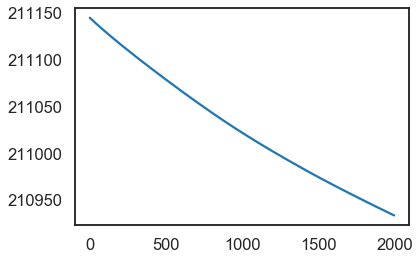

In [371]:
plt.plot(losses[3000:])

In [25]:
z = model.most_likely_states(data)

In [26]:
z[0]

2

In [27]:
x_predict = k_step_prediction_for_coupled_momentum_model(model, z, data, momentum_vecs=momentum_vecs, features=features)

([], <a list of 0 Text yticklabel objects>)

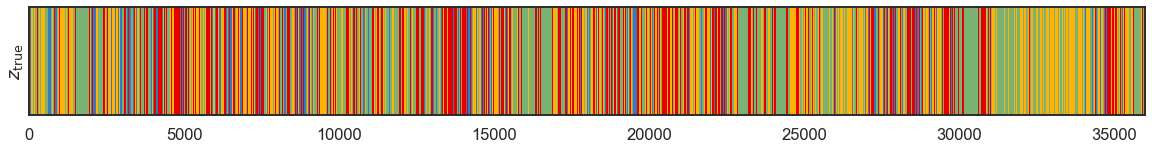

In [28]:
plt.figure(figsize=(20,2))
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

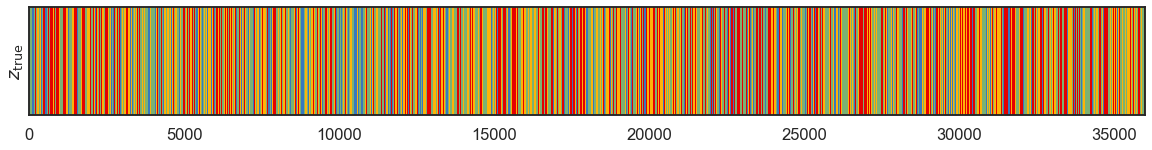

In [108]:
plt.figure(figsize=(20,2))
plt.imshow(sample_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

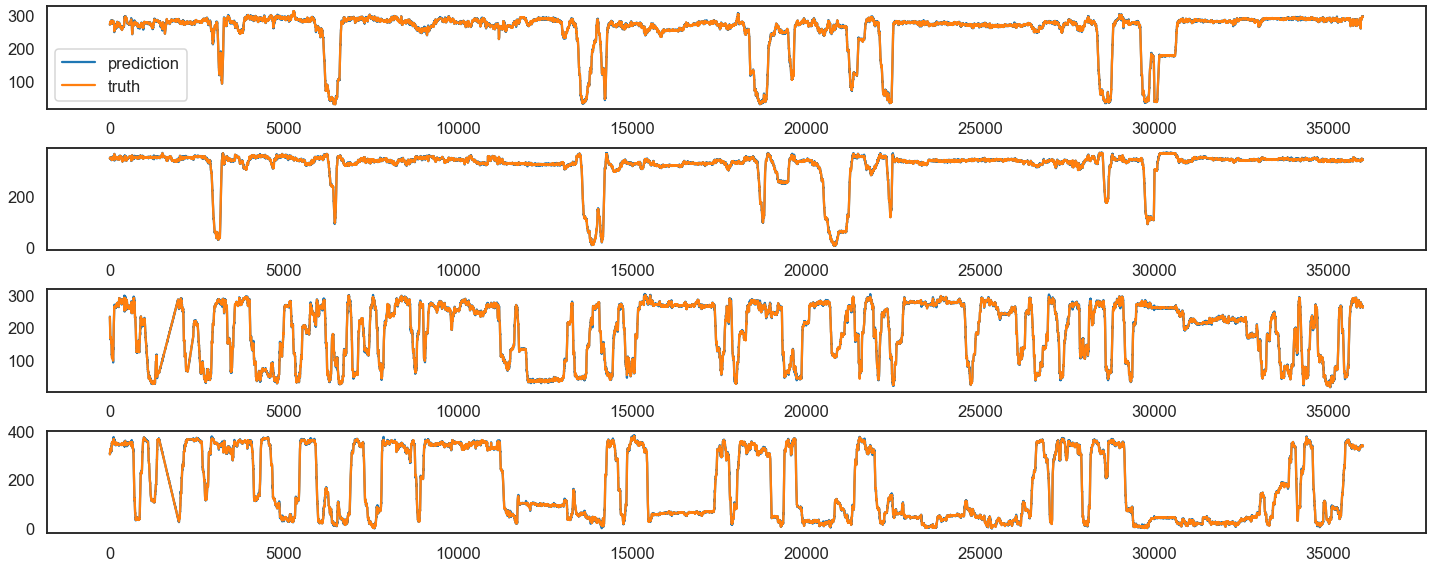

In [29]:
plt.figure(figsize=(20,8))

plt.subplot(4,1,1)
plt.plot(x_predict[:,0], label='prediction')
plt.plot(data[:,0].numpy(), label='truth')
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_predict[:,1], label='prediction')
plt.plot(data[:,1].numpy(), label='truth')

plt.subplot(4,1,3)
plt.plot(x_predict[:,2], label='prediction')
plt.plot(data[:,2].numpy(), label='truth')

plt.subplot(4,1,4)
plt.plot(x_predict[:,3], label='prediction')
plt.plot(data[:,3].numpy(), label='truth')

plt.tight_layout()

In [30]:
z_num = [sum(z==k) for k in range(K)]
z_num

[4134, 9557, 10275, 12034]

In [31]:
torch.exp(model.observation.log_sigmas)

tensor([[1.6593, 1.9706, 3.3724, 3.5793],
        [1.4980, 1.5377, 0.9712, 0.9550],
        [0.5437, 0.5433, 1.8987, 1.7462],
        [0.5763, 0.5512, 0.5451, 0.5114]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

In [32]:
diff = x_predict - data.numpy()

In [45]:
z[np.where(diff[:,0]>20)]

array([], dtype=int64)

# check samples

In [46]:
sample_z, sample_x = model.sample(T)

In [47]:
[sum(sample_z == k) for k in range(K)]

[4429, 9904, 10168, 11499]

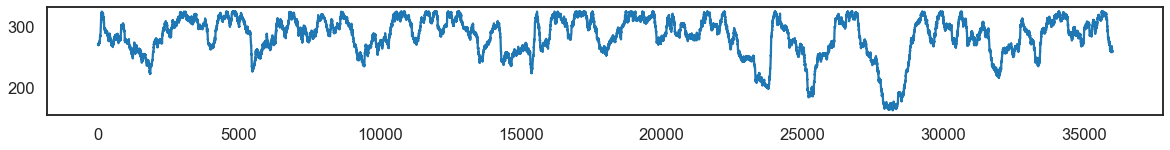

In [69]:
plt.figure(figsize=(20,2))
plt.plot(sample_x[:,0])
#plt.plot(sample_x[:,1])

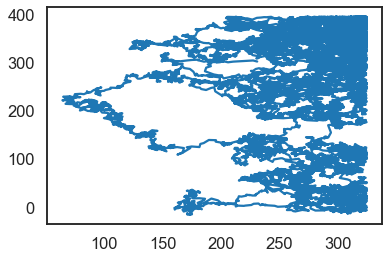

In [71]:
#plt.plot(sample_x[:,0], sample_x[:,1])
plt.plot(sample_x[:,2], sample_x[:,3])

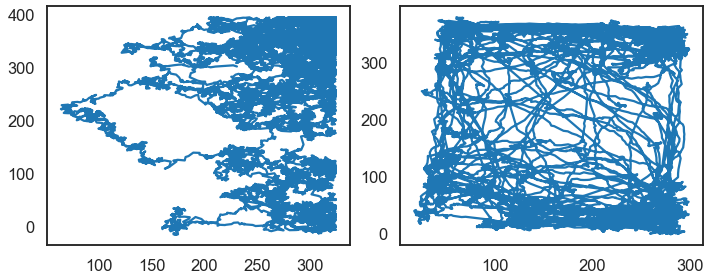

In [50]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
#plt.plot(sample_x[:,0], sample_x[:,1])
plt.plot(sample_x[:,2], sample_x[:,3])

plt.subplot(1,2,2)
#plt.plot(data[:,0].numpy(), data[:,1].numpy())
plt.plot(data[:,2].numpy(), data[:,3].numpy())

plt.tight_layout()

# check speed

In [51]:
speed_sample_x = np.diff(sample_x, axis=0)

In [52]:
sample_z[np.where(speed_sample_x[:,3] > 10)[0]+1]

array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [53]:
speed_x = np.diff(data.numpy(), axis=0)

In [54]:
speed_x_predict = np.diff(x_predict, axis=0)

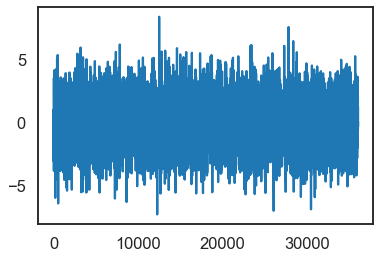

In [63]:
plt.plot(speed_sample_x[:,1])

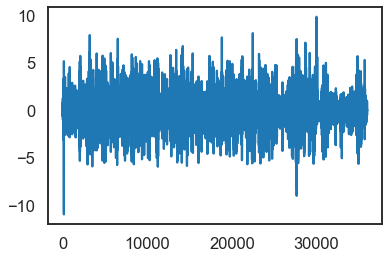

In [64]:
plt.plot(speed_x[:,1])

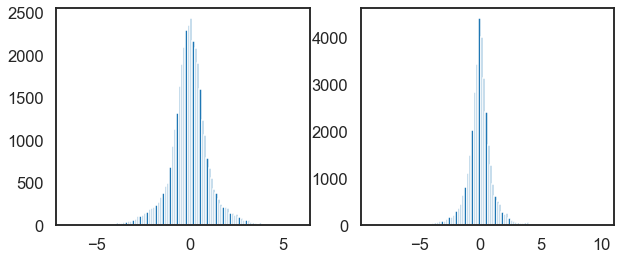

In [56]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1,2,1)
ax1.hist(speed_sample_x[:,0], bins=100);
#ax1.set_xlim((-10, 10))

plt.subplot(1,2,2)
plt.hist(speed_x[:,0], bins=100);

# check space occupancy

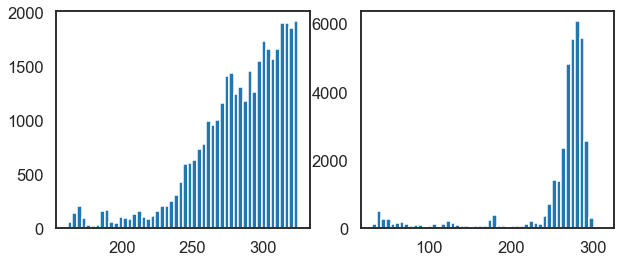

In [65]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(sample_x[:,0], bins=50);

plt.subplot(1,2,2)
plt.hist(data[:,0].numpy(), bins=50);

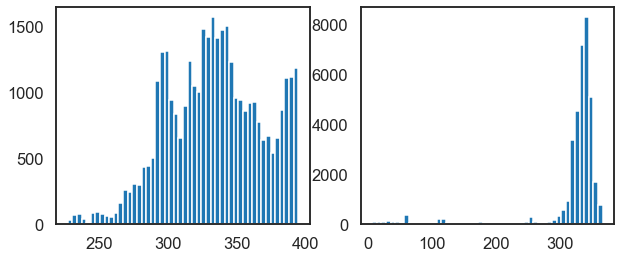

In [66]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(sample_x[:,1], bins=50);

plt.subplot(1,2,2)
plt.hist(data[:,1].numpy(), bins=50);

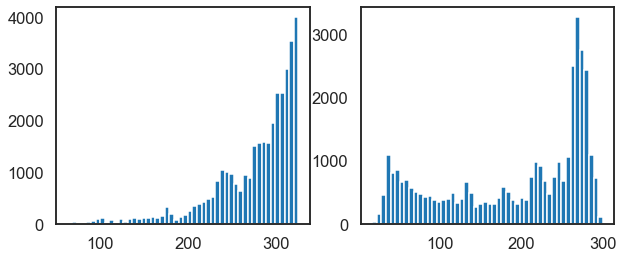

In [67]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(sample_x[:,2], bins=50);

plt.subplot(1,2,2)
plt.hist(data[:,2].numpy(), bins=50);

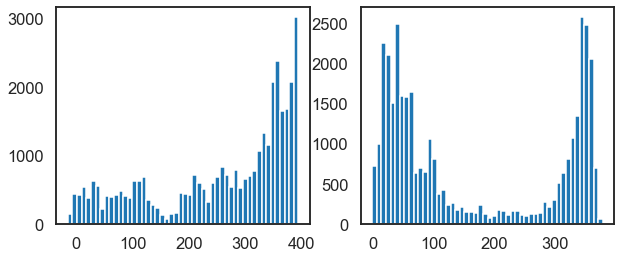

In [68]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(sample_x[:,3], bins=50);

plt.subplot(1,2,2)
plt.hist(data[:,3].numpy(), bins=50);

In [79]:
mse = np.mean(diff**2, axis=0)

In [80]:
mse

array([2.24672048, 2.55772007, 5.33438375, 5.35916741])

# look into the dynamics

See how different z, and how momentum vector corresponds to different behaviors

#### 1. Condition on fix z sequence (say z = [1,1,1,....,1,1,]), see how the sampled observations look like.

In [72]:
z_num

[4134, 9557, 10275, 12034]

In [99]:
fix_t = 1000
fix_z0 = np.zeros(fix_t)
fix_z1 = np.ones(fix_t)
fix_z2 = 2 * np.ones(fix_t)
fix_z3 = 3 * np.ones(fix_t)

In [100]:
sample_z0 = model.sample_condition_on_zs(zs=fix_z0, x0=data[0])
sample_z1 = model.sample_condition_on_zs(zs=fix_z1, x0=data[0])
sample_z2 = model.sample_condition_on_zs(zs=fix_z2, x0=data[0])
sample_z3 = model.sample_condition_on_zs(zs=fix_z3, x0=data[0])


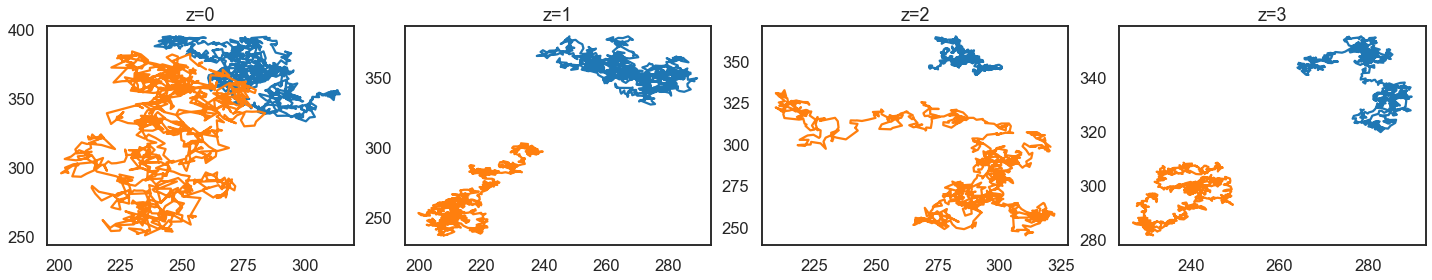

In [102]:
plt.figure(figsize=(20, 4))

ax1 = plt.subplot(1,4,1)
plt.plot(sample_z0[:,0], sample_z0[:,1])
plt.plot(sample_z0[:,2], sample_z0[:,3])
ax1.set_title("z=0")

ax2 = plt.subplot(1,4,2)
plt.plot(sample_z1[:,0], sample_z1[:,1])
plt.plot(sample_z1[:,2], sample_z1[:,3])
ax2.set_title("z=1")

ax3 = plt.subplot(1,4,3)
plt.plot(sample_z2[:,0], sample_z2[:,1])
plt.plot(sample_z2[:,2], sample_z2[:,3])
ax3.set_title("z=2")

ax4 = plt.subplot(1,4,4)
plt.plot(sample_z3[:,0], sample_z3[:,1])
plt.plot(sample_z3[:,2], sample_z3[:,3])
ax4.set_title("z=3")

plt.tight_layout()

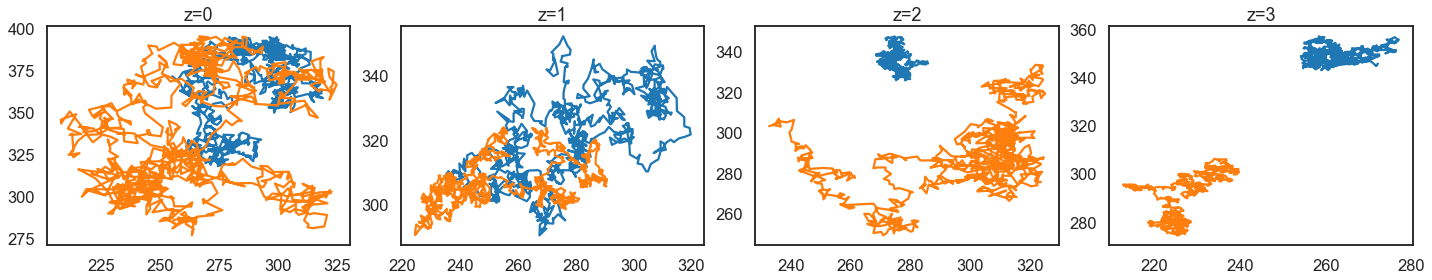

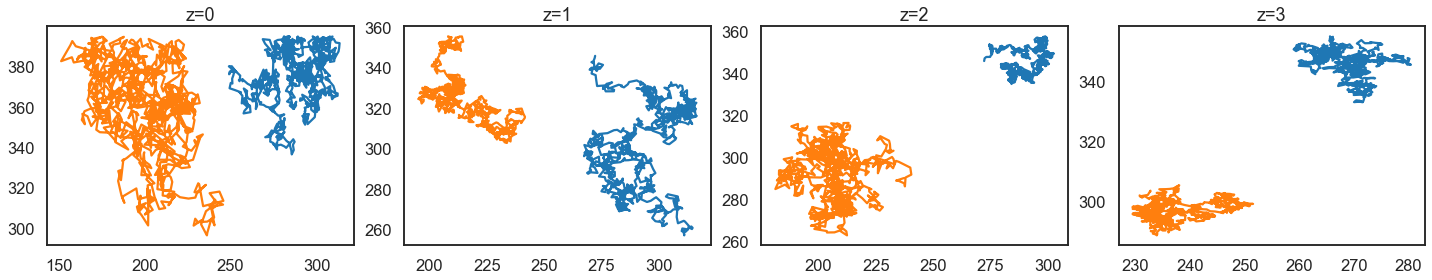

#### 2. quiver plots

In [115]:
bounds

array([[  5, 325],
       [-15, 395],
       [  5, 325],
       [-15, 395]])

In [170]:
XX, YY = np.meshgrid(np.linspace(0, 320, 30), 
                     np.linspace(0, 370, 30))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (900,2) grid values

In [171]:
def get_XY_other(pos, shape=(900,1)):
    return np.tile(pos[None,], shape)

In [172]:
XY_other = get_XY_other(np.array([320/2, 370/2]))

In [174]:
XY_virgin = np.concatenate((XY, XY_other), axis=1)
XY_mother = np.concatenate((XY_other, XY), axis=1)

In [175]:
XY_virgin.shape

(900, 4)

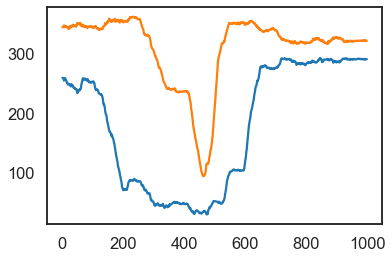

In [176]:
plt.plot(data[6000:7000,0].numpy())
plt.plot(data[6000:7000,1].numpy())

In [177]:
print(momentum_vecs[6300])
print(momentum_vecs[7000])

tensor([-0.7330, -1.0062, -0.5861, -1.2842], dtype=torch.float64)
tensor([ 2.3127e-02, -5.8448e-04, -2.2855e+00,  3.2550e-01],
       dtype=torch.float64)


Note: be careful in making transformation. Have to provide momentum as input, as it cannot be computed from the grid values, because the grid values are batch data, not sequential data.

In [257]:
momentum_vec_0 = torch.tensor([-1, -1, 0, 0], dtype=torch.float64) # (4, )
quiver_momentum_vecs_0 = momentum_vec_0 * torch.ones(900, 1, dtype=torch.float64)

In [258]:
m_tran = model.observation.transformation

In [259]:
XY_virgin_next_0 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_0)

In [260]:
dXY_virgin_0 = XY_virgin_next_0.detach().numpy() - XY_virgin[:, None]

### the other mouse is at the arena center

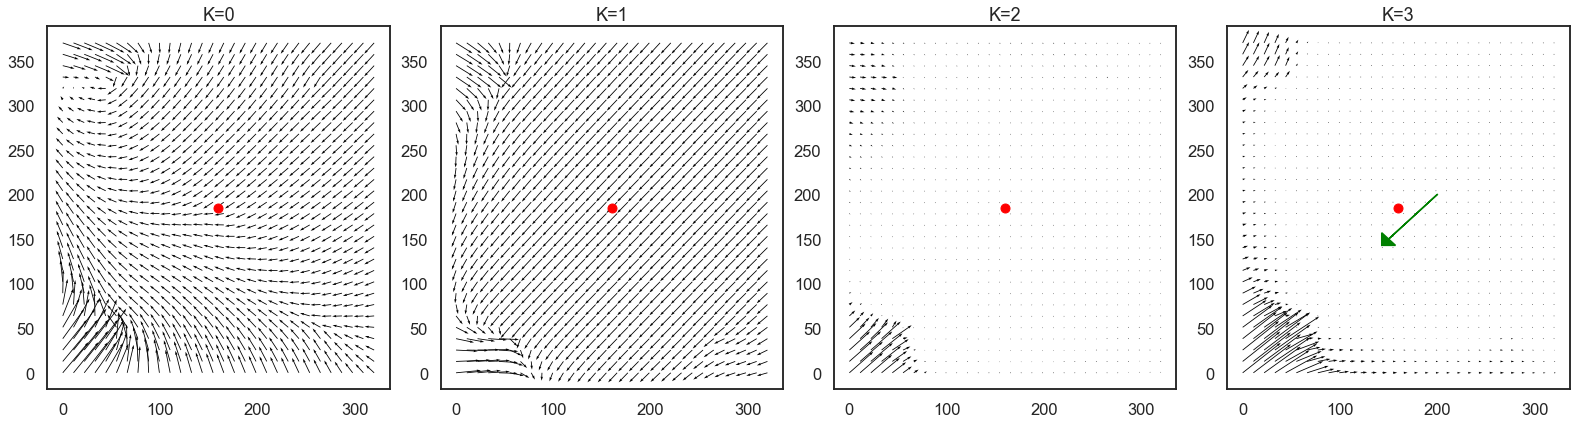

In [261]:
plot_quiver(XY_virgin, dXY_virgin, 'virgin', [320/2, 370/2], scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20)

In [262]:
momentum_vec_1 = torch.tensor([1, 1, 0, 0], dtype=torch.float64) # (4, )
quiver_momentum_vecs_1 = momentum_vec_1 * torch.ones(900, 1, dtype=torch.float64)

In [263]:
XY_virgin_next_1 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_1)
dXY_virgin_1 = XY_virgin_next_1.detach().numpy() - XY_virgin[:, None]

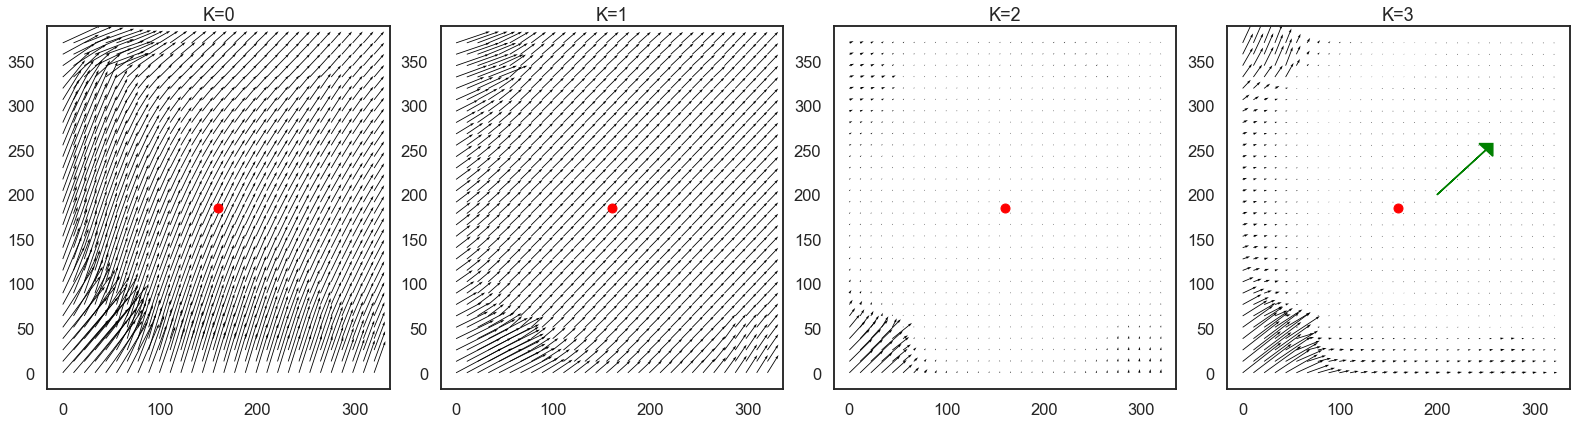

In [265]:
plot_quiver(XY_virgin, dXY_virgin_1, 'virgin', [320/2, 370/2], scale=0.1)
plt.arrow(200, 200, 50, 50, color='green', head_length = 10, head_width = 20)

In [266]:
momentum_vec_2 = torch.tensor([0.02, -0.02, 0, 0], dtype=torch.float64) # (4, )
quiver_momentum_vecs_2 = momentum_vec_2 * torch.ones(900, 1, dtype=torch.float64)

In [267]:
XY_virgin_next_2 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_2)
dXY_virgin_2 = XY_virgin_next_2.detach().numpy() - XY_virgin[:, None]

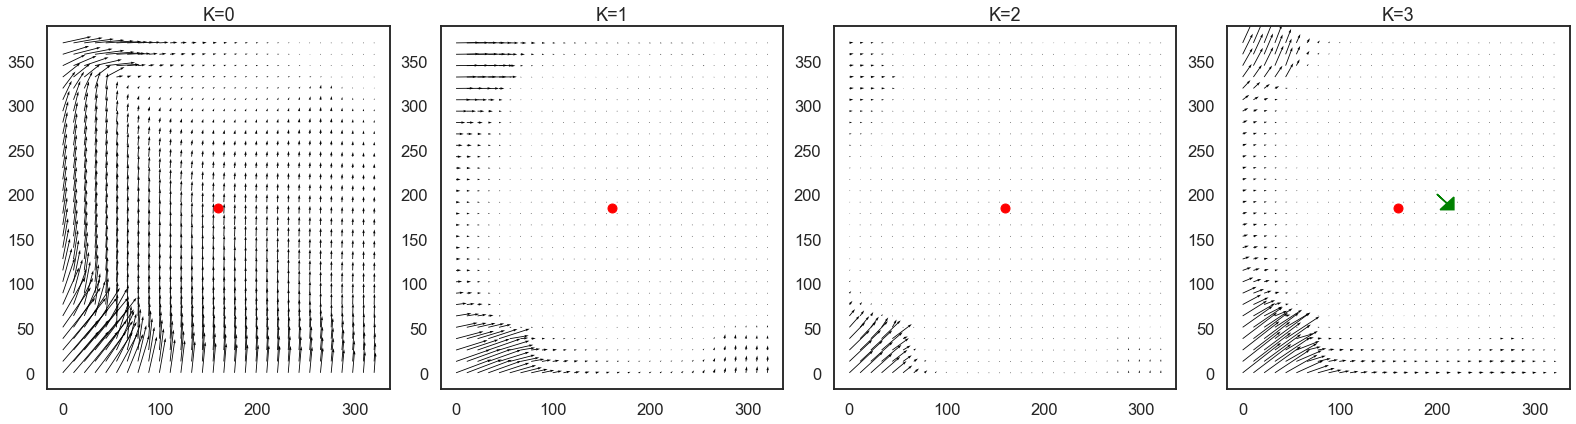

In [268]:
plot_quiver(XY_virgin, dXY_virgin_2, 'virgin', [320/2, 370/2], scale=0.1)
plt.arrow(200, 200, 10, -10, color='green', head_length = 10, head_width = 20)

##### moving the location of the other mouse to nest

In [269]:
NEST = np.array([270, 330])

In [270]:
XY_other = get_XY_other(NEST)
XY_virgin = np.concatenate((XY, XY_other), axis=1)
XY_mother = np.concatenate((XY_other, XY), axis=1)

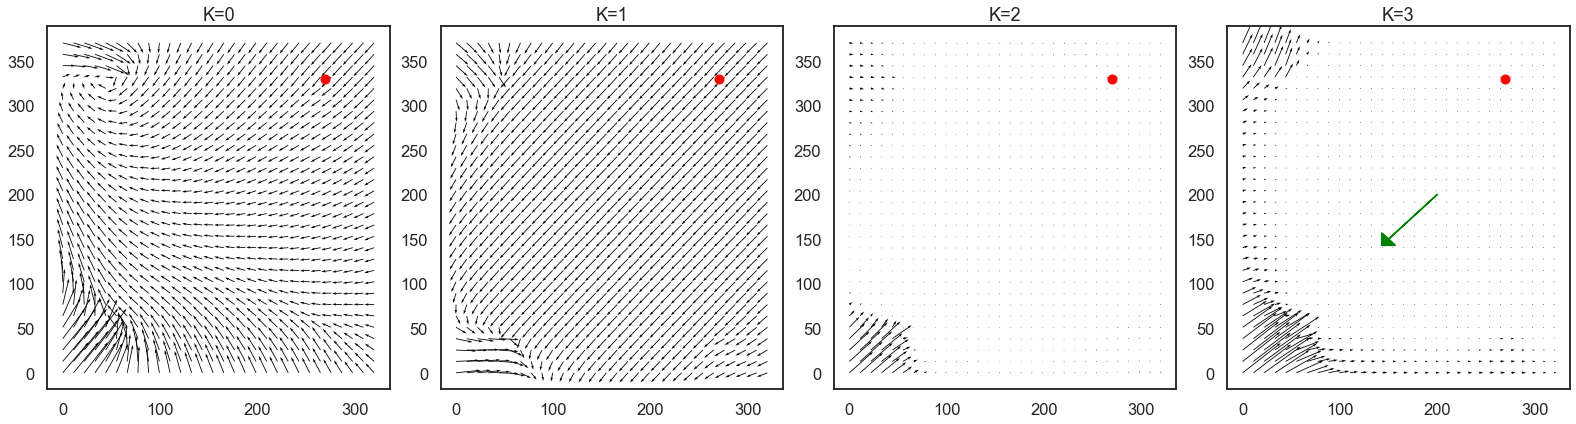

In [271]:
XY_virgin_next_0 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_0)
dXY_virgin_0 = XY_virgin_next_0.detach().numpy() - XY_virgin[:, None]
plot_quiver(XY_virgin, dXY_virgin_0, 'virgin', NEST, scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20);

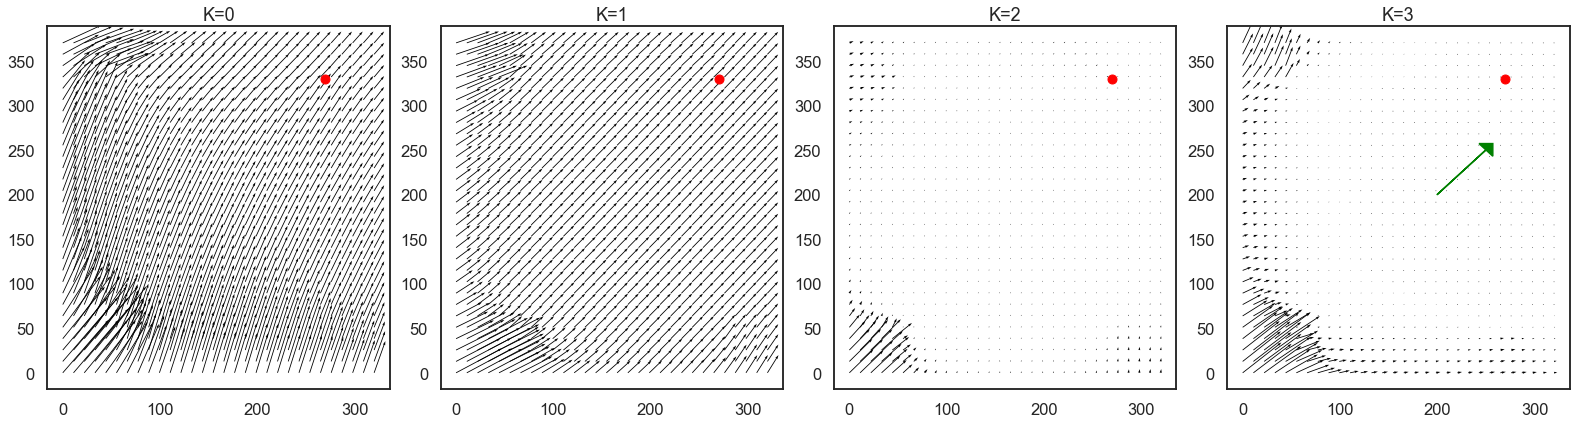

In [273]:
XY_virgin_next_1 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_1)
dXY_virgin_1 = XY_virgin_next_1.detach().numpy() - XY_virgin[:, None]
plot_quiver(XY_virgin, dXY_virgin_1, 'virgin', nest, scale=0.1)
plt.arrow(200, 200, 50, 50, color='green', head_length = 10, head_width = 20);

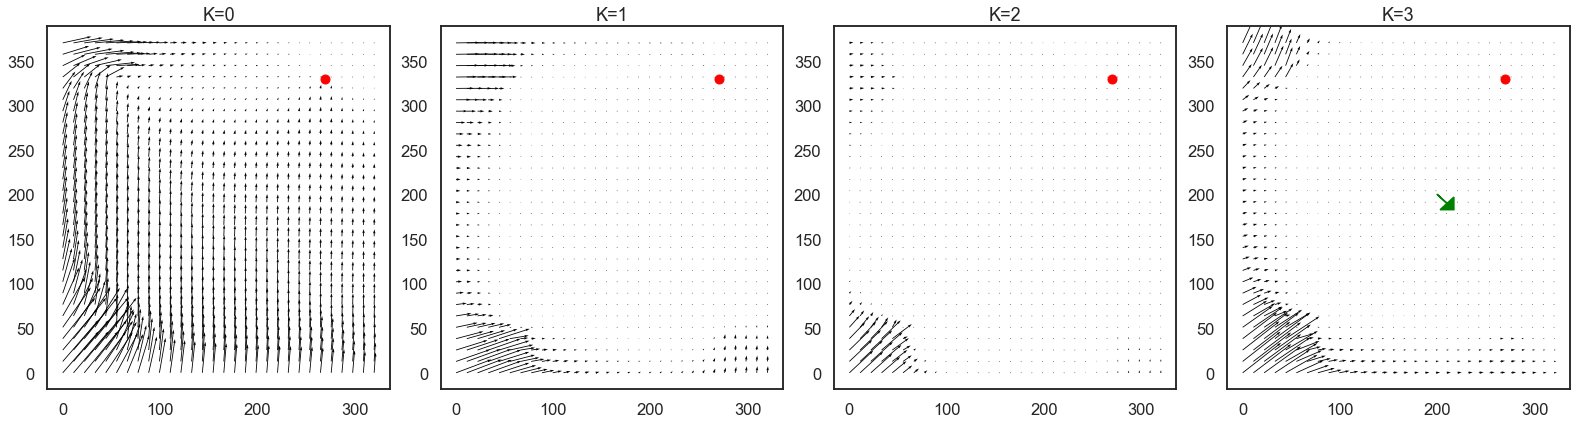

In [309]:
XY_virgin_next_2 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_2)
dXY_virgin_2 = XY_virgin_next_2.detach().numpy() - XY_virgin[:, None]
plot_quiver(XY_virgin, dXY_virgin_2, 'virgin', nest, scale=0.1)
plt.arrow(200, 200, 10, -10, color='green', head_length = 10, head_width = 20);

### the other mouse is at the water tank

In [313]:
WATER = np.array([50, 50])

In [314]:
XY_other = get_XY_other(WATER)
XY_virgin = np.concatenate((XY, XY_other), axis=1)
XY_mother = np.concatenate((XY_other, XY), axis=1)

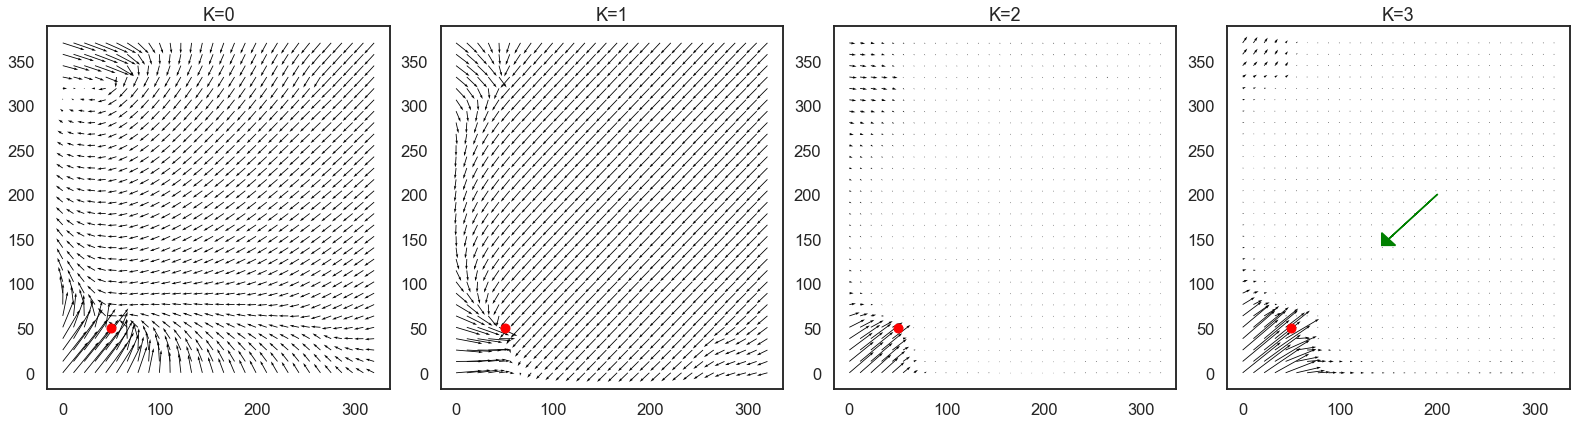

In [316]:
XY_virgin_next_0 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_0)
dXY_virgin_0 = XY_virgin_next_0.detach().numpy() - XY_virgin[:, None]
plot_quiver(XY_virgin, dXY_virgin_0, 'virgin', WATER, scale=0.1)
plt.arrow(200, 200, -50, -50, color='green', head_length = 10, head_width = 20);

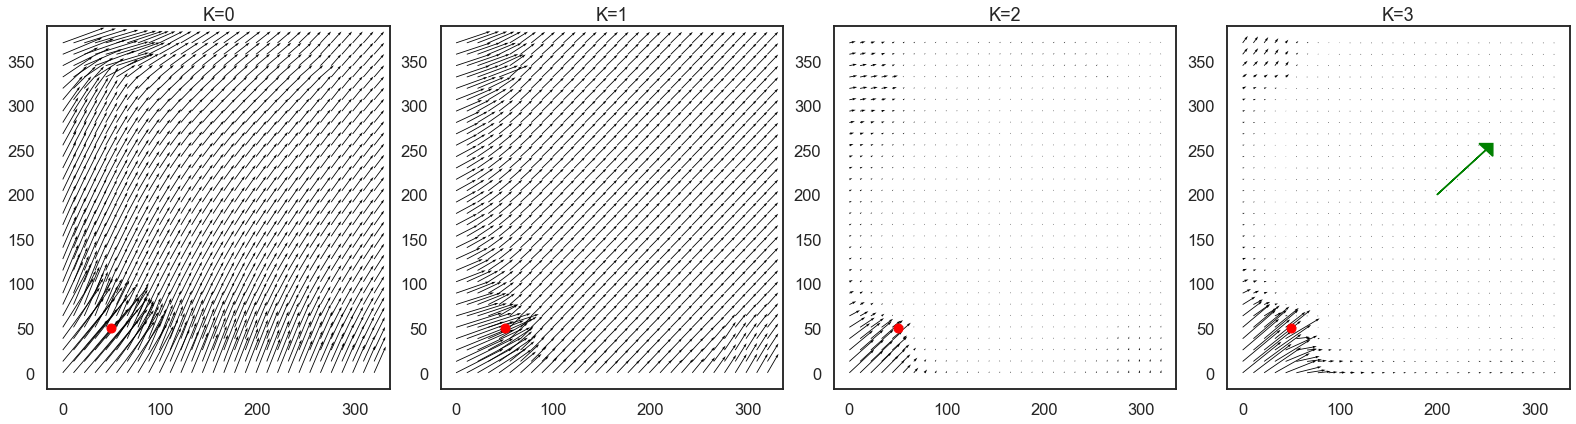

In [317]:
XY_virgin_next_1 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_1)
dXY_virgin_1 = XY_virgin_next_1.detach().numpy() - XY_virgin[:, None]
plot_quiver(XY_virgin, dXY_virgin_1, 'virgin', WATER, scale=0.1)
plt.arrow(200, 200, 50, 50, color='green', head_length = 10, head_width = 20);

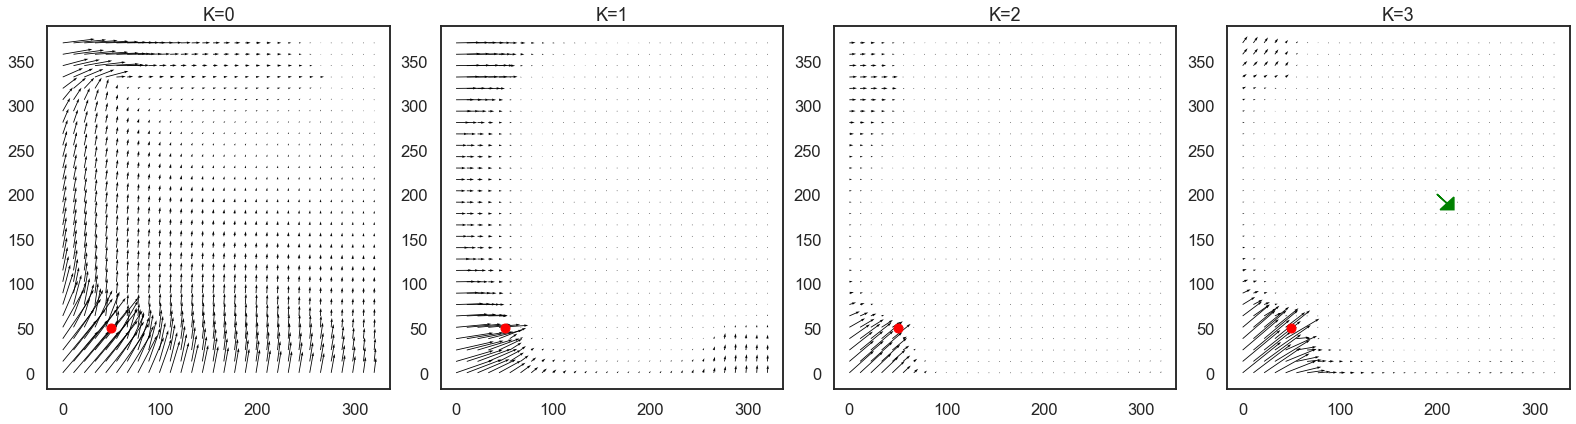

In [318]:
XY_virgin_next_2 = m_tran.transform(torch.tensor(XY_virgin, dtype=torch.float64), momentum_vecs=quiver_momentum_vecs_2)
dXY_virgin_2 = XY_virgin_next_2.detach().numpy() - XY_virgin[:, None]
plot_quiver(XY_virgin, dXY_virgin_2, 'virgin', WATER, scale=0.1)
plt.arrow(200, 200, 10, -10, color='green', head_length = 10, head_width = 20);

In [185]:
torch.sigmoid(m_tran.alpha)

tensor([[0.5124, 0.6241, 0.8501, 0.9828],
        [0.5520, 0.6128, 0.0509, 0.0262],
        [0.0092, 0.0629, 0.4898, 0.4372],
        [0.0149, 0.0153, 0.0328, 0.0898]], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)

In [163]:
dXY_virgin.shape

(100, 4, 4)

In [ ]:
dXY_virgin[0]

### illustration of momentum vector

(0, 300)

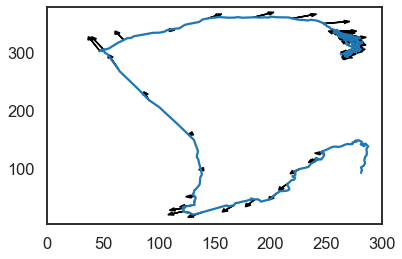

In [312]:
plt.plot(data[14000:15000,0].numpy(), data[14000:15000,1].numpy())

for t in np.arange(14050, 15000, 10):
    plt.arrow(data[t, 0].numpy(), data[t, 1].numpy(),
             5*momentum_vecs[t,0].numpy(), 5*momentum_vecs[t,1].numpy(),
             color='black', head_width=5, head_length=5)
    
plt.xlim(0, 300)

In [275]:
momentum_vecs.shape

torch.Size([35999, 4])

In [305]:
from project_ssms.momentum_utils import get_momentum_in_batch

def compute_momentum_vecs(inputs, lags):
    # compute normalized momentum vec
    momentum_vec_a = get_momentum_in_batch(inputs[:, 0:2], lags=lags)  # (T, 2)
    momentum_vec_b = get_momentum_in_batch(inputs[:, 2:4], lags=lags)  # (T, 2)
    momentum_vec = torch.cat([momentum_vec_a, momentum_vec_b], dim=1)  # (T, 4)
    return momentum_vec

## Fit a shorter momentum vecs

In [306]:
momentum_vecs_shorter = compute_momentum_vecs(data[:-1], 20)

(0, 300)

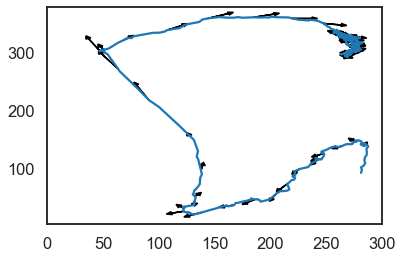

In [311]:
plt.plot(data[14000:15000,0].numpy(), data[14000:15000,1].numpy())

for t in np.arange(14020, 15000, 10):
    plt.arrow(data[t, 0].numpy(), data[t, 1].numpy(),
             5*momentum_vecs_shorter[t,0].numpy(), 5*momentum_vecs_shorter[t,1].numpy(),
             color='black', head_width=5, head_length=5)
    
plt.xlim(0, 300)

### plot the momentum vec of the sampled data

In [339]:
momentum_vecs_sample = compute_momentum_vecs(torch.tensor(sample_x, dtype=torch.float64)[:-1], 50)

In [340]:
out = momentum_vecs_sample.numpy()

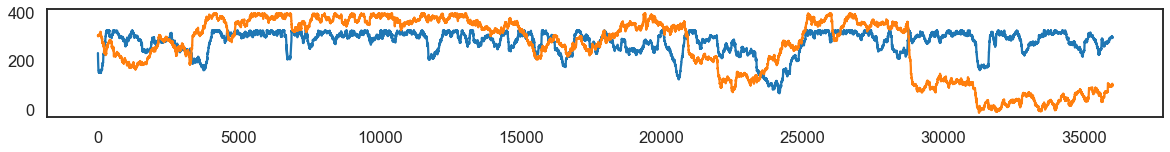

In [336]:
plt.figure(figsize=(20,2))
plt.plot(sample_x[:,2])
plt.plot(sample_x[:,3])

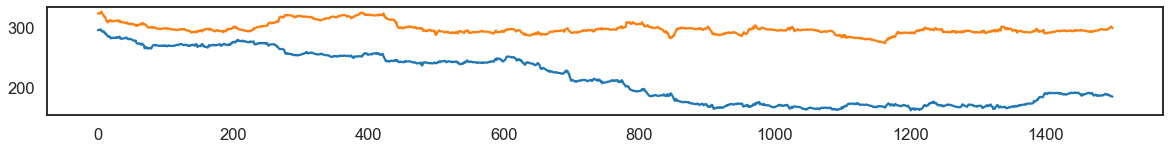

In [332]:
plt.figure(figsize=(20,2))
plt.plot(sample_x[27000:28500,0])
plt.plot(sample_x[27000:28500,1])

(150, 350)

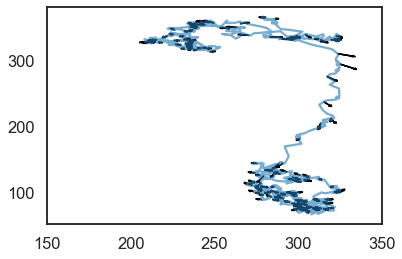

In [356]:
plt.plot(sample_x[28000:30000,2], sample_x[28000:30000,3], alpha=0.6)

for t in np.arange(28000, 30000, 10):
    plt.arrow(sample_x[t, 2], sample_x[t, 3],
             5*momentum_vecs_sample[t,2].numpy(), 5*momentum_vecs_sample[t,3].numpy(),
             color='black', head_width=2, head_length=2)
    
plt.xlim(150, 350)

## Condition the infered dynamics, and then generate samples

In [352]:
sample_inferred = model.sample_condition_on_zs(zs=z, x0=data[0])

In [353]:
from project_ssms.plot_utils import plot_2_mice

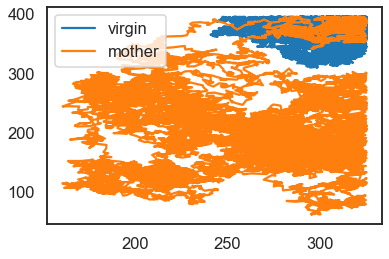

In [355]:
plot_2_mice(sample_inferred)

### check the distribution of momentum_vecs

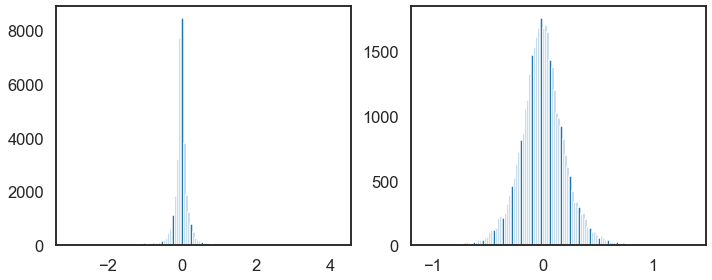

In [401]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(momentum_vecs[:,0], bins=120);
plt.subplot(1,2,2)
plt.hist(momentum_vecs_sample[:,0], bins=120);
plt.tight_layout()